In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import make_scorer, r2_score
import time
from sklearn import linear_model
from datetime import datetime
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNetCV 
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
print("Version de Python :", sys.version)


Version de Python : 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]


## 5 - Modélisation

In [3]:
final_df=pd.read_csv("final_df.csv")

In [4]:
# final_df.info()

In [5]:
final_df['CouncilDistrictCode']=final_df['CouncilDistrictCode'].astype('object')  
final_df['Age_Cluster']=final_df['Age_Cluster'].astype('object')                              

In [6]:
final_df.shape

(1444, 67)

### 5.1 - Préparation

#### 5.1.1 - Features / Target

In [7]:
X=final_df[[ 
'ratio_elec',
'Office',
'PrimaryPropertyType',
'Supermarket/Grocery Store',
'ratio_gas',
'Worship Facility',
'Other',
'Age',
'Restaurant',
'K-12 School',
'Retail Store',
'Other - Recreation',
'Laboratory',
'Distance_to_City_Center',
'Neighborhood', 
'Gas_Using']]
y=final_df["GHGEmissionsIntensity"]

In [8]:
X.shape, y.shape

((1444, 16), (1444,))

#### 5.1.2 - Division du jeu de données en train/test

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

print("Train set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)


Train set: (1010, 16) (1010,)
Test set: (434, 16) (434,)


#### 5.1.3 - One Hot Encoding

In [10]:
X_train_encoded=pd.get_dummies(X_train)
X_test_encoded=pd.get_dummies(X_test)

In [11]:
# X_train_encoded.columns

#### 5.1.4 - Normalisation

In [12]:
# NORMALISATION

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

In [13]:
pd.DataFrame(X_train_scaled).describe().round(1)

0       1       2       3       4       5       6       7       8   \
count  1010.0  1010.0  1010.0  1010.0  1010.0  1010.0  1010.0  1010.0  1010.0   
mean     -0.0     0.5     0.0     0.1     0.0     0.1     0.1     0.0     0.0   
std       0.5     0.6     0.1     0.5     0.2     0.3     0.6     0.1     0.2   
min      -1.4     0.0     0.0    -0.4     0.0     0.0    -0.9     0.0     0.0   
25%      -0.5     0.0     0.0    -0.4     0.0     0.0    -0.4     0.0     0.0   
50%       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
75%       0.5     1.0     0.0     0.6     0.0     0.0     0.6     0.0     0.0   
max       0.5     4.6     1.2     1.6     1.6     3.4     1.1     1.0     4.5   

           9   ...      35      36      37      38      39      40      41  \
count  1010.0  ...  1010.0  1010.0  1010.0  1010.0  1010.0  1010.0  1010.0   
mean      0.1  ...     0.2     0.1     0.2     0.1     0.1     0.0     0.1   
std       0.2  ...     0.4     0.3     0.4     0.3     0.3     0.2     0.2   
min       0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
25%       0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
50%       0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
75%       0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
max       1.3  ...     1.0     1.0     1.0     1.0     1.0     1.0     1.0   

           42      43      44  
count  1010.0  1010.0  1010.0  
mean      0.0     0.0     0.0  
std       0.2     0.1     0.1  
min       0.0     0.0     0.0  
25%       0.0     0.0     0.0  
50%       0.0     0.0     0.0  
75%       0.0     0.0     0.0  
max       1.0     1.0     1.0  

[8 rows x 45 columns]

In [14]:
pd.DataFrame(X_test_scaled).describe().round(1)

0      1      2      3      4      5      6      7      8      9   \
count  434.0  434.0  434.0  434.0  434.0  434.0  434.0  434.0  434.0  434.0   
mean    -0.1    0.5    0.0    0.1    0.1    0.1    0.0    0.0    0.0    0.1   
std      0.5    0.6    0.2    0.5    0.2    0.3    0.6    0.1    0.2    0.3   
min     -1.4    0.0    0.0   -0.4    0.0    0.0   -0.9    0.0    0.0    0.0   
25%     -0.4    0.0    0.0   -0.4    0.0    0.0   -0.4    0.0    0.0    0.0   
50%     -0.1    0.0    0.0    0.1    0.0    0.0   -0.0    0.0    0.0    0.0   
75%      0.5    1.0    0.0    0.5    0.0    0.0    0.5    0.0    0.0    0.0   
max      0.5    1.8    1.0    1.6    1.2    1.8    1.1    1.0    1.6    1.5   

       ...     35     36     37     38     39     40     41     42     43  \
count  ...  434.0  434.0  434.0  434.0  434.0  434.0  434.0  434.0  434.0   
mean   ...    0.2    0.1    0.2    0.1    0.1    0.0    0.1    0.1    0.0   
std    ...    0.4    0.2    0.4    0.3    0.3    0.2    0.3    0.2    0.1   
min    ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
25%    ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
50%    ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
75%    ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
max    ...    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   

          44  
count  434.0  
mean     0.0  
std      0.2  
min      0.0  
25%      0.0  
50%      0.0  
75%      0.0  
max      1.0  

[8 rows x 45 columns]

Nous avions observé que la distribution de notre target ne suivait pas une loi normale. Par conséquent nous allons la passer à l'échelle logarithmique.

#### 5.1.5 - Passage au log de la target

In [15]:
# PASSAGE AU LOG DE LA TARGET

y_train_log = np.log1p(y_train)  #  np.log1p pour éviter les problèmes avec des valeurs de zéro
y_test_log = np.log1p(y_test)

In [16]:
y_train_log.describe()

count    1010.000000
mean        0.764802
std         0.584440
min         0.009950
25%         0.292670
50%         0.625938
75%         1.077558
max         3.557916
Name: GHGEmissionsIntensity, dtype: float64

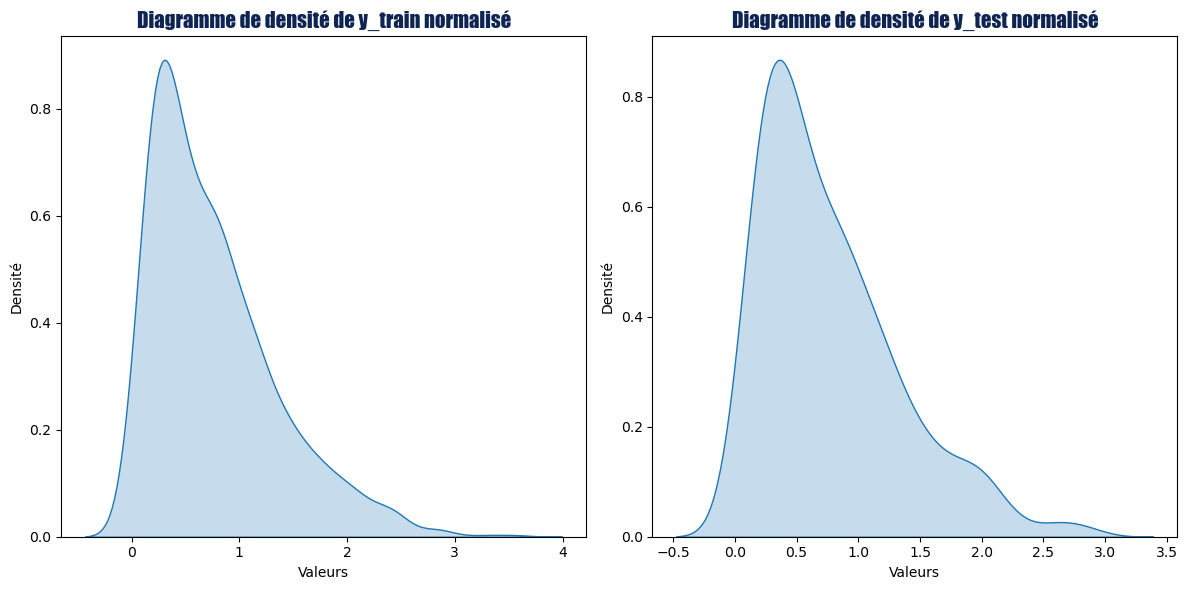

In [17]:
# Création de la figure et des axes
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Diagramme de densité pour y_train
sns.kdeplot(y_train_log, shade=True, ax=axes[0])

# Ajout de labels et de titre pour y_train
axes[0].set_xlabel('Valeurs')
axes[0].set_ylabel('Densité')
axes[0].set_title("Diagramme de densité de y_train normalisé", fontsize=15, weight="bold", fontname="Impact", color="#0e2452")

# Diagramme de densité pour y_test
sns.kdeplot(y_test_log, shade=True, ax=axes[1])

# Ajout de labels et de titre pour y_test
axes[1].set_xlabel('Valeurs')
axes[1].set_ylabel('Densité')
axes[1].set_title("Diagramme de densité de y_test normalisé", fontsize=15, weight="bold", fontname="Impact", color="#0e2452")

# Ajustement de l'espacement entre les sous-graphiques
plt.tight_layout()

# Affichage du graphique
plt.show()

#### 5.1.6 - Création du score pour le r2 ajuste

In [18]:
def r2_ajuste(y_true, y_pred, X):
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    k = X.shape[1]
    r2_ajuste = 1 - (1 - r2) * (n - 1) / (n - k - 1)
    return r2_ajuste

adjusted_r2_scorer = make_scorer(r2_ajuste, greater_is_better=True, X=X)


### 5.2 - Baseline = LinearRegression

In [19]:
# Définition du modèle
model_baseline = linear_model.LinearRegression()

# Entrainement du modèle
start_time = time.time()
model_baseline.fit(X_train_scaled, y_train_log)  
end_time = time.time()
total_time_lr = end_time - start_time
total_time_lr

0.1607060432434082

In [20]:
# Evaluation du train
y_train_pred = model_baseline.predict(X_train_scaled)
r2_train = r2_score(y_train_log, y_train_pred)
adjusted_r2_train = r2_ajuste(y_train_log, y_train_pred, X_train_scaled)

# Evaluation du test
y_test_pred = model_baseline.predict(X_test_scaled)
r2_test = r2_score(y_test_log, y_test_pred)
adjusted_r2_test = r2_ajuste(y_test_log, y_test_pred, X_test_scaled)


In [21]:
# Renvoie des résultats dans un df
results = pd.DataFrame({
'Model_Name': ["Linear regression"],
'Score_R2_Train': [r2_train],
'Score_R2_Test': [r2_test],
'Score_R2_Ajuste_Train': [adjusted_r2_train],
'Score_R2_Ajuste_Test': [adjusted_r2_test],
'Training_Time': [total_time_lr],
'Best_Parameters': ["None"]
    })

results

Model_Name  Score_R2_Train  Score_R2_Test  Score_R2_Ajuste_Train  \
0  Linear regression        0.727507       0.623824               0.714787   

   Score_R2_Ajuste_Test  Training_Time Best_Parameters  
0              0.580196       0.160706            None

In [22]:
# Création d'un DataFrame vide pour stocker les résultats
all_models_results = pd.DataFrame()

def evaluate_grid_search(grid_search, X_train, y_train, X_test, y_test, model_name):


    # Entrainement + temps
    start_time = datetime.now()
    grid_search.fit(X_train, y_train)
    end_time = datetime.now()
    training_time =  (end_time - start_time).total_seconds()
    
    # Best model 
    best_model = grid_search.best_estimator_
    
    # Best parameters
    best_params = grid_search.best_params_
    
    # Evaluation du train
    y_train_pred = best_model.predict(X_train)
    r2_train = r2_score(y_train, y_train_pred)
    adjusted_r2_train = r2_ajuste(y_train, y_train_pred, X_train)

    # Evaluation du test
    y_test_pred = best_model.predict(X_test)
    r2_test = r2_score(y_test, y_test_pred)
    adjusted_r2_test = r2_ajuste(y_test, y_test_pred, X_test)

    
    # Renvoie des résultats dans un df
    results = pd.DataFrame({
        'Model_Name': [model_name],
        'Score_R2_Train': [r2_train],
        'Score_R2_Test': [r2_test],
        'Score_R2_Ajuste_Train': [adjusted_r2_train],
        'Score_R2_Ajuste_Test': [adjusted_r2_test],
        'Training_Time': [training_time],
        'Best_Parameters': [best_params]
    })
    return results

### 5.3 - Autres modèles Linéaires

#### 5.3.1 - Ridge Régression

In [23]:
model = Ridge()

param_grid_ridge = {
    'alpha': [0.001, 0.01, 0.1, 0.3, 0.7, 1, 10, 50, 100],
}

grid_search_ridge = GridSearchCV(
    model,
    param_grid=param_grid_ridge,
    scoring={'r2': 'r2', 'adjusted_r2': adjusted_r2_scorer},
    refit='adjusted_r2', 
    cv=5,  
    verbose=1
)

In [24]:
models_results_ridge = evaluate_grid_search(grid_search_ridge, X_train_scaled, y_train_log, X_test_scaled, y_test_log, 'Régression Ridge').reset_index(drop=True)
all_results = pd.concat([results, models_results_ridge], ignore_index=True)
all_results

Fitting 5 folds for each of 9 candidates, totalling 45 fits


Model_Name  Score_R2_Train  Score_R2_Test  Score_R2_Ajuste_Train  \
0  Linear regression        0.727507       0.623824               0.714787   
1   Régression Ridge        0.726918       0.629847               0.714171   

   Score_R2_Ajuste_Test  Training_Time Best_Parameters  
0              0.580196       0.160706            None  
1              0.586917       0.119195  {'alpha': 0.3}

#### 5.3.2 - Lasso

In [25]:
model = Lasso()

param_grid_lasso = {
    'alpha': [0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0],
}

grid_search_lasso = GridSearchCV(
    model,
    param_grid=param_grid_lasso,
    scoring={'r2': 'r2', 'adjusted_r2': adjusted_r2_scorer},
    refit='adjusted_r2', 
    cv=5,  
    verbose=1
)

In [26]:
models_results_lasso = evaluate_grid_search(grid_search_lasso, X_train_scaled, y_train_log, X_test_scaled, y_test_log, 'Lasso').reset_index(drop=True)
all_results = pd.concat([all_results, models_results_lasso], ignore_index=True)
all_results

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Model_Name  Score_R2_Train  Score_R2_Test  Score_R2_Ajuste_Train  \
0  Linear regression        0.727507       0.623824               0.714787   
1   Régression Ridge        0.726918       0.629847               0.714171   
2              Lasso        0.719766       0.639536               0.706685   

   Score_R2_Ajuste_Test  Training_Time   Best_Parameters  
0              0.580196       0.160706              None  
1              0.586917       0.119195    {'alpha': 0.3}  
2              0.597729       0.144821  {'alpha': 0.001}

#### 5.3.3 - Elastic Net

In [27]:
model = ElasticNetCV()

param_grid_elasticnet = {
    'l1_ratio': [0.2, 0.5, 0.8],
}

grid_search_elasticnet = GridSearchCV(
    model,
    param_grid=param_grid_elasticnet,
    scoring={'r2': 'r2', 'adjusted_r2': adjusted_r2_scorer},
    refit='adjusted_r2', 
    cv=5,  
    verbose=1
)

In [28]:
pd.set_option('display.max_colwidth', None)
models_results_elasticnet = evaluate_grid_search(grid_search_elasticnet, X_train_scaled, y_train_log, X_test_scaled, y_test_log, 'ElasticNet').reset_index(drop=True)
all_models_results = pd.concat([all_models_results, models_results_elasticnet], ignore_index=True)
all_results= pd.concat([all_results,all_models_results], ignore_index=True)
all_results

Fitting 5 folds for each of 3 candidates, totalling 15 fits


Model_Name  Score_R2_Train  Score_R2_Test  Score_R2_Ajuste_Train  \
0  Linear regression        0.727507       0.623824               0.714787   
1   Régression Ridge        0.726918       0.629847               0.714171   
2              Lasso        0.719766       0.639536               0.706685   
3         ElasticNet        0.723075       0.638990               0.710148   

   Score_R2_Ajuste_Test  Training_Time    Best_Parameters  
0              0.580196       0.160706               None  
1              0.586917       0.119195     {'alpha': 0.3}  
2              0.597729       0.144821   {'alpha': 0.001}  
3              0.597120       2.032951  {'l1_ratio': 0.2}

### 5.4 - SVM à noyau - (Kernel "rbf")

In [29]:
model_svm = svm.SVR()

param_grid_svm_SVR = {
    'C': [0.1, 1, 5, 10, 100, 150, 200],
    'gamma': [1e-7, 1e-4],
    'epsilon': [0.1, 0.2, 0.5, 0.3],
    'kernel': ['linear', 'rbf', 'poly']  # Ajouter les différents noyaux à tester
}

grid_search_svm_SVR = GridSearchCV(
    model_svm,
    param_grid=param_grid_svm_SVR,
    scoring={'r2': 'r2', 'adjusted_r2': adjusted_r2_scorer},
    refit='adjusted_r2', 
    cv=5,  
    verbose=1
)

In [30]:
pd.set_option('display.max_colwidth', None)
models_results_param_grid_svm_SVR= evaluate_grid_search(grid_search_svm_SVR, X_train_scaled, y_train_log, X_test_scaled, y_test_log, 'svm_SVR').reset_index(drop=True)
all_results = pd.concat([all_results, models_results_param_grid_svm_SVR], ignore_index=True)
all_results

Fitting 5 folds for each of 168 candidates, totalling 840 fits


Model_Name  Score_R2_Train  Score_R2_Test  Score_R2_Ajuste_Train  \
0  Linear regression        0.727507       0.623824               0.714787   
1   Régression Ridge        0.726918       0.629847               0.714171   
2              Lasso        0.719766       0.639536               0.706685   
3         ElasticNet        0.723075       0.638990               0.710148   
4            svm_SVR        0.715115       0.635583               0.701817   

   Score_R2_Ajuste_Test  Training_Time  \
0              0.580196       0.160706   
1              0.586917       0.119195   
2              0.597729       0.144821   
3              0.597120       2.032951   
4              0.593318     167.730970   

                                                Best_Parameters  
0                                                          None  
1                                                {'alpha': 0.3}  
2                                              {'alpha': 0.001}  
3                                             {'l1_ratio': 0.2}  
4  {'C': 1, 'epsilon': 0.1, 'gamma': 1e-07, 'kernel': 'linear'}

### 5.5 - Méthodes ensemblistes

#### 5.5.1 - Bagging = RandomForestRegressor

In [31]:
# Création d'une fonction pour faire un plot des HP

def plot_hyperparameter_tuning(grid_search, param_name, score_name):
    grid_search.fit(X_train_scaled, y_train_log)
    cv_results=grid_search.cv_results_
    # Extraire les données nécessaires de cv_results
    param_values = np.array(cv_results[f'param_{param_name}'].data)
    score_values = cv_results[f'mean_{score_name}']

    # Créer le plot
    plt.figure(figsize=(5, 5))
    plt.plot(param_values, score_values, marker='o', linestyle='-')

    # Ajouter des étiquettes et un titre
    plt.xlabel(f'{param_name}')
    plt.ylabel(f'Moyenne du score {score_name}')
    plt.title(f'Impact de {param_name} sur le score {score_name}')

    # Afficher le plot
    plt.grid(True)
    plt.show()

In [32]:
model = RandomForestRegressor(random_state=42)

param_grid_RF_regressor = {
    'n_estimators': [5,20,50,100,200,300,400,500], # nombre d'arbres dans la forêt
#     'max_depth': [2,3], # profondeur de chaque arbre
#     'min_samples_split': [5,10,50], # nombre minimum d'échantillons requis pour effectuer une division
#     'min_samples_leaf': [5,10,50] # nombre minimum d'échantillons requis pour être une feuille
}

grid_search_RF_regressor = GridSearchCV(
    model,
    param_grid=param_grid_RF_regressor,
    scoring={'r2': 'r2', 'adjusted_r2': adjusted_r2_scorer},
    refit='adjusted_r2', 
    cv=5,  
    verbose=1,
    n_jobs=-1
)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


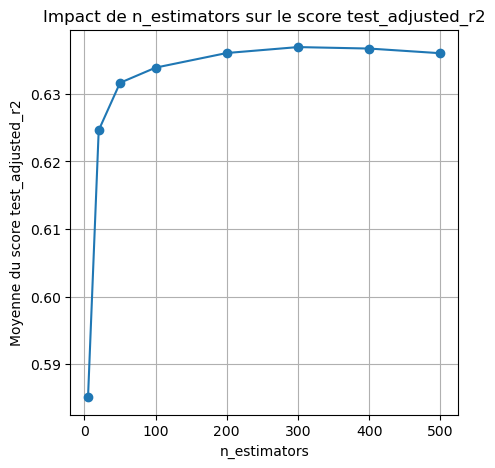

In [33]:
plot_hyperparameter_tuning(grid_search_RF_regressor, "n_estimators", 'test_adjusted_r2')

In [34]:
model = RandomForestRegressor(random_state=42)

param_grid_RF_regressor = {
#    'n_estimators': [5,20,50,100,200,300,400,500], # nombre d'arbres dans la forêt
     'max_depth': [1,2,3,4,5,6,7,8,9,10,15,20], # profondeur de chaque arbre
#     'min_samples_split': [5,10,50], # nombre minimum d'échantillons requis pour effectuer une division
#     'min_samples_leaf': [5,10,50] # nombre minimum d'échantillons requis pour être une feuille
}

grid_search_RF_regressor = GridSearchCV(
    model,
    param_grid=param_grid_RF_regressor,
    scoring={'r2': 'r2', 'adjusted_r2': adjusted_r2_scorer},
    refit='adjusted_r2', 
    cv=5,  
    verbose=1,
    n_jobs=-1
)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


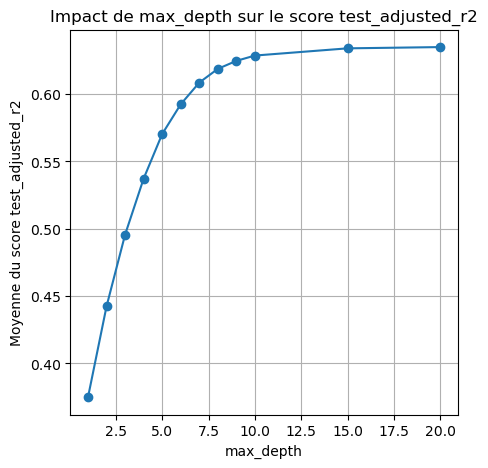

In [35]:
plot_hyperparameter_tuning(grid_search_RF_regressor, "max_depth", 'test_adjusted_r2')

In [36]:
model = RandomForestRegressor(random_state=42)

param_grid_RF_regressor = {
#    'n_estimators': [5,20,50,100,200,300,400,500], # nombre d'arbres dans la forêt
#      'max_depth': [1,2,3,4], # profondeur de chaque arbre
    'min_samples_split': [5,10,15,20], # nombre minimum d'échantillons requis pour effectuer une division
#     'min_samples_leaf': [5,10,50] # nombre minimum d'échantillons requis pour être une feuille
}

grid_search_RF_regressor = GridSearchCV(
    model,
    param_grid=param_grid_RF_regressor,
    scoring={'r2': 'r2', 'adjusted_r2': adjusted_r2_scorer},
    refit='adjusted_r2', 
    cv=5,  
    verbose=1,
    n_jobs=-1
)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


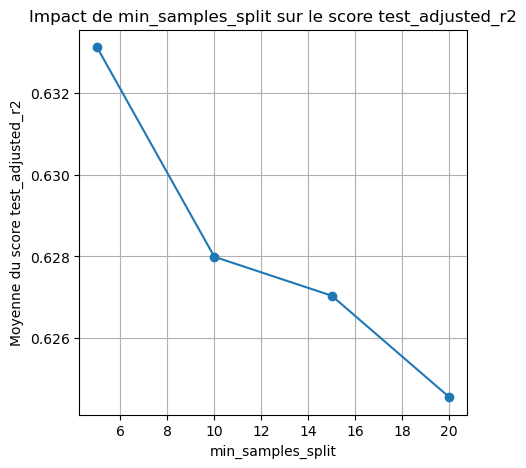

In [37]:
plot_hyperparameter_tuning(grid_search_RF_regressor, "min_samples_split", 'test_adjusted_r2')

In [38]:
model = RandomForestRegressor(random_state=42)

param_grid_RF_regressor = {
#    'n_estimators': [5,20,50,100,200,300,400,500], # nombre d'arbres dans la forêt
#      'max_depth': [1,2,3,4], # profondeur de chaque arbre
#    'min_samples_split': [5,10,50], # nombre minimum d'échantillons requis pour effectuer une division
     'min_samples_leaf': [5,10,15] # nombre minimum d'échantillons requis pour être une feuille
}

grid_search_RF_regressor = GridSearchCV(
    model,
    param_grid=param_grid_RF_regressor,
    scoring={'r2': 'r2', 'adjusted_r2': adjusted_r2_scorer},
    refit='adjusted_r2', 
    cv=5,  
    verbose=1,
    n_jobs=-1
)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


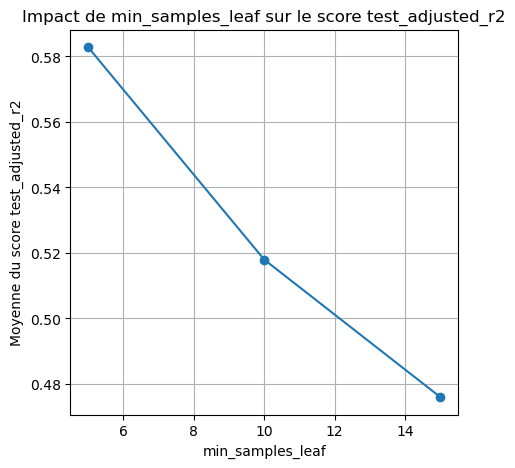

In [39]:
plot_hyperparameter_tuning(grid_search_RF_regressor, "min_samples_leaf", 'test_adjusted_r2')

In [40]:
model = RandomForestRegressor(random_state=42)

param_grid_RF_regressor = {
'n_estimators': [100,200,500], # nombre d'arbres dans la forêt
'max_depth': [5,10,15], # profondeur de chaque arbre
'min_samples_split': [5,10,15], # nombre minimum d'échantillons requis pour effectuer une division
'min_samples_leaf': [5,10,15] # nombre minimum d'échantillons requis pour être une feuille
}

grid_search_RF_regressor = GridSearchCV(
    model,
    param_grid=param_grid_RF_regressor,
    scoring={'r2': 'r2', 'adjusted_r2': adjusted_r2_scorer},
    refit='adjusted_r2', 
    cv=5,  
    verbose=1,
    n_jobs=-1
)

In [41]:
pd.set_option('display.max_colwidth', None)
models_results_RF_regressor= evaluate_grid_search(grid_search_RF_regressor, X_train_scaled, y_train_log, X_test_scaled, y_test_log, 'RF_regressor').reset_index(drop=True)
all_results = pd.concat([all_results, models_results_RF_regressor], ignore_index=True)
all_results

Fitting 5 folds for each of 81 candidates, totalling 405 fits


Model_Name  Score_R2_Train  Score_R2_Test  Score_R2_Ajuste_Train  \
0  Linear regression        0.727507       0.623824               0.714787   
1   Régression Ridge        0.726918       0.629847               0.714171   
2              Lasso        0.719766       0.639536               0.706685   
3         ElasticNet        0.723075       0.638990               0.710148   
4            svm_SVR        0.715115       0.635583               0.701817   
5       RF_regressor        0.817742       0.605713               0.809235   

   Score_R2_Ajuste_Test  Training_Time  \
0              0.580196       0.160706   
1              0.586917       0.119195   
2              0.597729       0.144821   
3              0.597120       2.032951   
4              0.593318     167.730970   
5              0.559983      96.182670   

                                                                         Best_Parameters  
0                                                                                   None  
1                                                                         {'alpha': 0.3}  
2                                                                       {'alpha': 0.001}  
3                                                                      {'l1_ratio': 0.2}  
4                           {'C': 1, 'epsilon': 0.1, 'gamma': 1e-07, 'kernel': 'linear'}  
5  {'max_depth': 15, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 500}

#### 5.5.2 - Boosting = XGBoost (eXtreme Gradient Boosting) 

In [42]:
!pip install --upgrade xgboost

In [43]:
model = XGBRegressor(random_state=42)

param_grid_XGB = {
'learning_rate': [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]
# 'max_depth': [2,3],
# 'min_child_weight' :[5, 15,50,100],
# 'colsample_bytree': [0.3,0.4,0.5],
# #'subsample': [1],
}
 
grid_search_XGB = GridSearchCV(
    model,
    param_grid=param_grid_XGB,
    scoring={'r2': 'r2', 'adjusted_r2': adjusted_r2_scorer},
    refit='adjusted_r2', 
    cv=5,  
    verbose=1,
    n_jobs=-1
)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


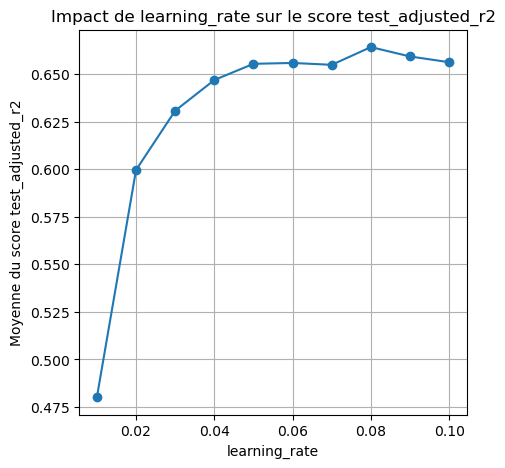

In [44]:
plot_hyperparameter_tuning(grid_search_XGB, "learning_rate", 'test_adjusted_r2')

In [45]:
model = XGBRegressor(random_state=42)

param_grid_XGB = {
#'learning_rate': [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]
 'max_depth': [1,2,3,4,5,6,7,8,9,10],
# 'min_child_weight' :[5, 15,50,100],
# 'colsample_bytree': [0.3,0.4,0.5],
# #'subsample': [1],
}
 
grid_search_XGB = GridSearchCV(
    model,
    param_grid=param_grid_XGB,
    scoring={'r2': 'r2', 'adjusted_r2': adjusted_r2_scorer},
    refit='adjusted_r2', 
    cv=5,  
    verbose=1,
    n_jobs=-1
)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


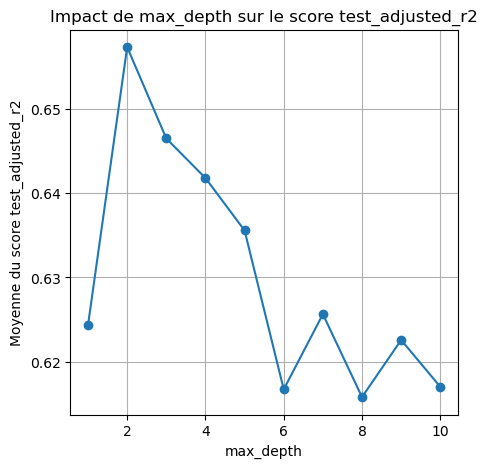

In [46]:
plot_hyperparameter_tuning(grid_search_XGB, "max_depth", 'test_adjusted_r2')

In [47]:
model = XGBRegressor(random_state=42)

param_grid_XGB = {
#'learning_rate': [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]
# 'max_depth': [1,2,3,4],
 'min_child_weight' :[5, 15,50,100],
# 'colsample_bytree': [0.3,0.4,0.5],
# #'subsample': [1],
}
 
grid_search_XGB = GridSearchCV(
    model,
    param_grid=param_grid_XGB,
    scoring={'r2': 'r2', 'adjusted_r2': adjusted_r2_scorer},
    refit='adjusted_r2', 
    cv=5,  
    verbose=1,
    n_jobs=-1
)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


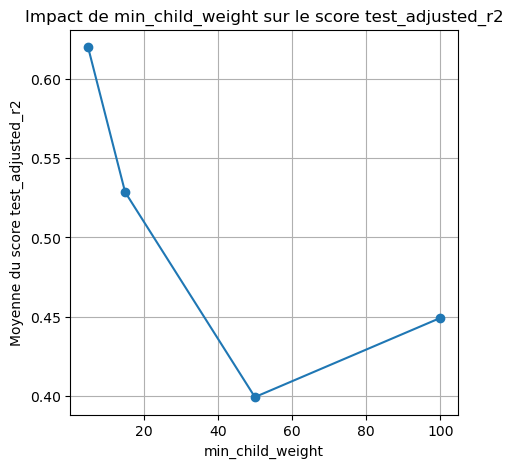

In [48]:
plot_hyperparameter_tuning(grid_search_XGB, "min_child_weight", 'test_adjusted_r2')

In [49]:
model = XGBRegressor(random_state=42)

param_grid_XGB = {
#'learning_rate': [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]
# 'max_depth': [1,2,3,4],
# 'min_child_weight' :[5, 15,50,100],
 'colsample_bytree': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
# #'subsample': [1],
}
 
grid_search_XGB = GridSearchCV(
    model,
    param_grid=param_grid_XGB,
    scoring={'r2': 'r2', 'adjusted_r2': adjusted_r2_scorer},
    refit='adjusted_r2', 
    cv=5,  
    verbose=1,
    n_jobs=-1
)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


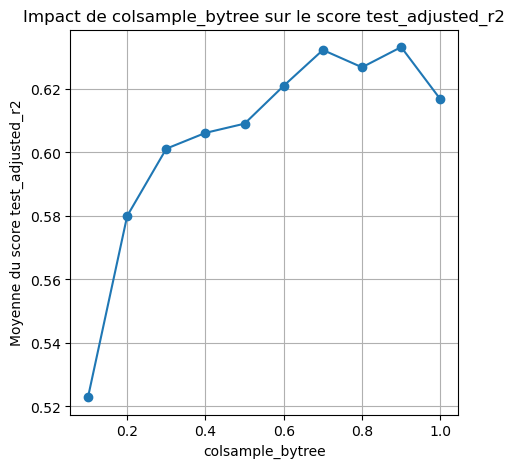

In [50]:
plot_hyperparameter_tuning(grid_search_XGB, "colsample_bytree", 'test_adjusted_r2')

In [51]:
model = XGBRegressor(random_state=42)

param_grid_XGB = {
#'learning_rate': [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]
# 'max_depth': [1,2,3,4],
# 'min_child_weight' :[5, 15,50,100],
# 'colsample_bytree': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
'subsample': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
}
 
grid_search_XGB = GridSearchCV(
    model,
    param_grid=param_grid_XGB,
    scoring={'r2': 'r2', 'adjusted_r2': adjusted_r2_scorer},
    refit='adjusted_r2', 
    cv=5,  
    verbose=1,
    n_jobs=-1
)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


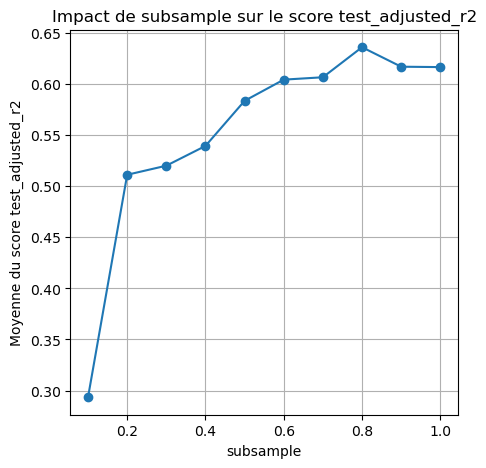

In [52]:
plot_hyperparameter_tuning(grid_search_XGB, "subsample", 'test_adjusted_r2')

In [53]:
model = XGBRegressor(random_state=42)

param_grid_XGB = {
'learning_rate': [0.06,0.07,0.08],
'max_depth': [3,4,5],
'min_child_weight' :[10,15],
'colsample_bytree': [0.4,1],
'subsample': [0.6,1]
}
 
grid_search_XGB = GridSearchCV(
    model,
    param_grid=param_grid_XGB,
    scoring={'r2': 'r2', 'adjusted_r2': adjusted_r2_scorer},
    refit='adjusted_r2', 
    cv=5,  
    verbose=1,
    n_jobs=-1
)

In [54]:
pd.set_option('display.max_colwidth', None)
models_results_XGB= evaluate_grid_search(grid_search_XGB, X_train_scaled, y_train_log, X_test_scaled, y_test_log, 'XGB').reset_index(drop=True)
all_results = pd.concat([all_results, models_results_XGB], ignore_index=True)
all_results

Fitting 5 folds for each of 72 candidates, totalling 360 fits


Model_Name  Score_R2_Train  Score_R2_Test  Score_R2_Ajuste_Train  \
0  Linear regression        0.727507       0.623824               0.714787   
1   Régression Ridge        0.726918       0.629847               0.714171   
2              Lasso        0.719766       0.639536               0.706685   
3         ElasticNet        0.723075       0.638990               0.710148   
4            svm_SVR        0.715115       0.635583               0.701817   
5       RF_regressor        0.817742       0.605713               0.809235   
6                XGB        0.790067       0.638400               0.780267   

   Score_R2_Ajuste_Test  Training_Time  \
0              0.580196       0.160706   
1              0.586917       0.119195   
2              0.597729       0.144821   
3              0.597120       2.032951   
4              0.593318     167.730970   
5              0.559983      96.182670   
6              0.596462       3.462248   

                                                                                          Best_Parameters  
0                                                                                                    None  
1                                                                                          {'alpha': 0.3}  
2                                                                                        {'alpha': 0.001}  
3                                                                                       {'l1_ratio': 0.2}  
4                                            {'C': 1, 'epsilon': 0.1, 'gamma': 1e-07, 'kernel': 'linear'}  
5                   {'max_depth': 15, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 500}  
6  {'colsample_bytree': 1, 'learning_rate': 0.08, 'max_depth': 4, 'min_child_weight': 10, 'subsample': 1}

## 6 - Analyse des résultats

### 6.1 - Consolidation des résultats

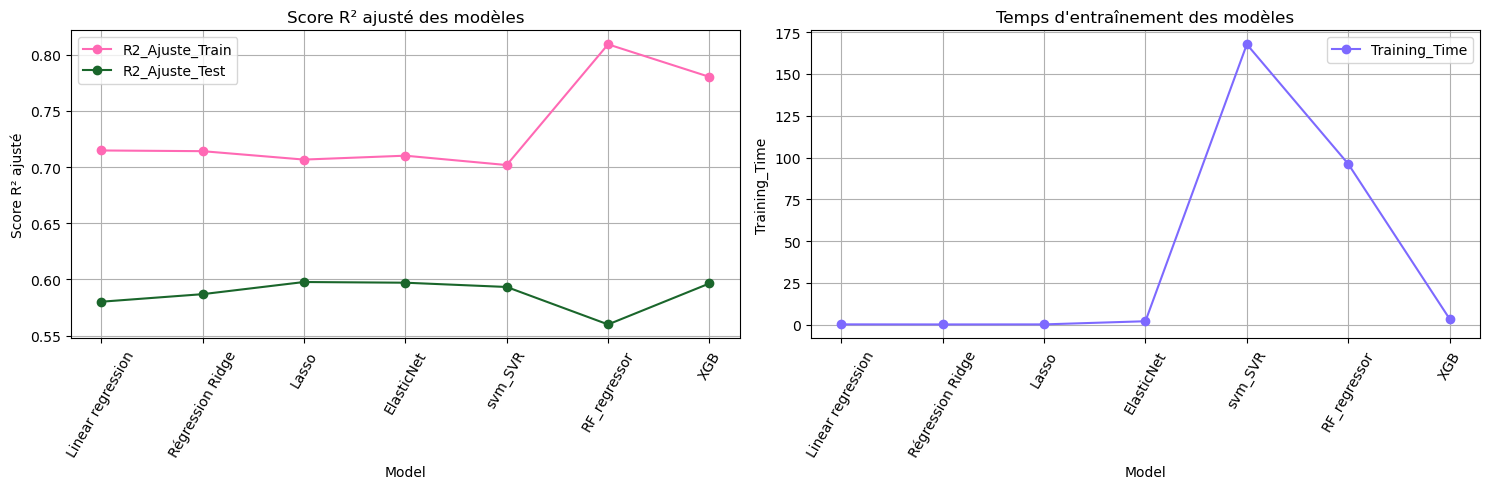

In [55]:
# Données pour le premier graphique
bar_positions = np.arange(len(all_results['Model_Name']))
r2_train = all_results['Score_R2_Ajuste_Train']
r2_test = all_results['Score_R2_Ajuste_Test']
Training_Time = all_results['Training_Time']

# Créer une figure avec deux sous-graphiques (1 ligne, 2 colonnes)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Premier sous-graphique : Score R² ajusté en ligne
axs[0].plot(bar_positions, r2_train, marker='o', linestyle='-', color='#ff69b4', label='R2_Ajuste_Train')
axs[0].plot(bar_positions, r2_test, marker='o', linestyle='-', color='#1a662b', label='R2_Ajuste_Test')
axs[0].set_xticks(bar_positions)
axs[0].set_xticklabels(all_results['Model_Name'], rotation=60)
axs[0].set_xlabel("Model")
axs[0].set_ylabel("Score R² ajusté")
axs[0].set_title("Score R² ajusté des modèles")
axs[0].legend()
axs[0].grid(True)

# Deuxième sous-graphique : Temps d'entraînement en ligne
axs[1].plot(bar_positions, Training_Time, marker='o', linestyle='-', color='#7d69ff', label='Training_Time')
axs[1].set_xticks(bar_positions)
axs[1].set_xticklabels(all_results['Model_Name'], rotation=60)
axs[1].set_xlabel("Model")
axs[1].set_ylabel("Training_Time")
axs[1].set_title("Temps d'entraînement des modèles")
axs[1].legend()
axs[1].grid(True)

# Ajustement de l'espacement entre les sous-graphiques
plt.tight_layout()

# Affichage de la figure
plt.show()



C'est le lasso qui présente le milleur rapport r² ajusté, overfitting et temps d'entrainement

### 6.2 - Analyse des prédictions du test

In [56]:
# Le meilleur modèle
best_model = grid_search_lasso.best_estimator_
best_model

Lasso(alpha=0.001)

In [57]:
# Faire des prédictions avec le meilleur modèle
y_pred_test = best_model.predict(X_test_scaled)


In [58]:
# Retour à l'exponentiel
y_pred_test_exp = np.expm1(y_pred_test)
y_test_exp = np.expm1(y_test_log)

#### 6.2.1 - Consolidation du X_test, y_test et y_pred_test

In [59]:
X_test.columns

Index(['ratio_elec', 'Office', 'PrimaryPropertyType',
       'Supermarket/Grocery Store', 'ratio_gas', 'Worship Facility', 'Other',
       'Age', 'Restaurant', 'K-12 School', 'Retail Store',
       'Other - Recreation', 'Laboratory', 'Distance_to_City_Center',
       'Neighborhood', 'Gas_Using'],
      dtype='object')

In [60]:
df_X_test = pd.DataFrame(X_test, columns=X_test.columns)
df_X_test.shape

(434, 16)

In [61]:
df_X_test.head()

ratio_elec    Office          PrimaryPropertyType  \
413     0.975664  0.574313                 Large Office   
316     0.209699  0.000000          Distribution Center   
1034    1.000000  0.000000               Medical Office   
65      1.000000  0.692935  Small- and Mid-Sized Office   
1024    0.641765  0.241603          Distribution Center   

      Supermarket/Grocery Store  ratio_gas  Worship Facility     Other  Age  \
413                         0.0   0.006877               0.0  0.190789   19   
316                         0.0   0.790301               0.0  0.000000   57   
1034                        0.0   0.000000               0.0  0.000000   38   
65                          0.0   0.000000               0.0  0.000000   38   
1024                        0.0   0.358235               0.0  0.000000   58   

      Restaurant  K-12 School  Retail Store  Other - Recreation  Laboratory  \
413          0.0          0.0           0.0                 0.0         0.0   
316          0.0          0.0           0.0                 0.0         0.0   
1034         0.0          0.0           0.0                 0.0         0.0   
65           0.0          0.0           0.0                 0.0         0.0   
1024         0.0          0.0           0.0                 0.0         0.0   

      Distance_to_City_Center           Neighborhood  Gas_Using  
413                  0.447302               DOWNTOWN          1  
316                  7.163782       GREATER DUWAMISH          1  
1034                10.940107                  NORTH          0  
65                   2.316570  MAGNOLIA & QUEEN ANNE          0  
1024                 4.316556       GREATER DUWAMISH          1

In [62]:
# Création d'un Dataframe avec les y_test and y_pred_test
df_results = pd.DataFrame({'y_test': y_test_exp, 'y_pred_test': y_pred_test_exp})
df_results.shape

(434, 2)

In [63]:
# Concaténation des 2
df_combined = pd.concat([df_X_test, df_results], axis=1)
df_combined.shape

(434, 18)

In [64]:
df_combined.head()

ratio_elec    Office          PrimaryPropertyType  \
413     0.975664  0.574313                 Large Office   
316     0.209699  0.000000          Distribution Center   
1034    1.000000  0.000000               Medical Office   
65      1.000000  0.692935  Small- and Mid-Sized Office   
1024    0.641765  0.241603          Distribution Center   

      Supermarket/Grocery Store  ratio_gas  Worship Facility     Other  Age  \
413                         0.0   0.006877               0.0  0.190789   19   
316                         0.0   0.790301               0.0  0.000000   57   
1034                        0.0   0.000000               0.0  0.000000   38   
65                          0.0   0.000000               0.0  0.000000   38   
1024                        0.0   0.358235               0.0  0.000000   58   

      Restaurant  K-12 School  Retail Store  Other - Recreation  Laboratory  \
413          0.0          0.0           0.0                 0.0         0.0   
316          0.0          0.0           0.0                 0.0         0.0   
1034         0.0          0.0           0.0                 0.0         0.0   
65           0.0          0.0           0.0                 0.0         0.0   
1024         0.0          0.0           0.0                 0.0         0.0   

      Distance_to_City_Center           Neighborhood  Gas_Using  y_test  \
413                  0.447302               DOWNTOWN          1    0.30   
316                  7.163782       GREATER DUWAMISH          1    1.91   
1034                10.940107                  NORTH          0    0.65   
65                   2.316570  MAGNOLIA & QUEEN ANNE          0    0.44   
1024                 4.316556       GREATER DUWAMISH          1    0.71   

      y_pred_test  
413      0.514974  
316      2.181769  
1034     0.436964  
65       0.342359  
1024     0.846869

Vérification que mon Dataframe récap est ok avec l'exemple de l'individu d'index 413

In [65]:
pd.set_option('display.max_rows', None)
final_df[(final_df['PrimaryPropertyType']=='Large Office')
         &(final_df['Neighborhood']=='DOWNTOWN')
         &(final_df['Age']==19)][['ratio_elec',
                                  'Office',
                                  'PrimaryPropertyType',
                                  'Supermarket/Grocery Store',
                                  'ratio_gas',
                                  'Worship Facility',
                                  'Other',
                                  'Age',
                                  'Restaurant',
                                  'K-12 School',
                                  'Retail Store']]

ratio_elec    Office PrimaryPropertyType  Supermarket/Grocery Store  \
413    0.975664  0.574313        Large Office                        0.0   

     ratio_gas  Worship Facility     Other  Age  Restaurant  K-12 School  \
413   0.006877               0.0  0.190789   19         0.0          0.0   

     Retail Store  
413           0.0

In [66]:
df_combined[(df_combined['PrimaryPropertyType']=='Large Office')
            &(df_combined['Neighborhood']=='DOWNTOWN')
            &(df_combined['Age']==19)][['ratio_elec',
                                  'Office',
                                  'PrimaryPropertyType',
                                  'Supermarket/Grocery Store',
                                  'ratio_gas',
                                  'Worship Facility',
                                  'Other',
                                  'Age',
                                  'Restaurant',
                                  'K-12 School',
                                  'Retail Store']]

ratio_elec    Office PrimaryPropertyType  Supermarket/Grocery Store  \
413    0.975664  0.574313        Large Office                        0.0   

     ratio_gas  Worship Facility     Other  Age  Restaurant  K-12 School  \
413   0.006877               0.0  0.190789   19         0.0          0.0   

     Retail Store  
413           0.0

C'est ok, pas de pbl d'index

In [67]:
df_combined['écart_true_pred'] = abs(df_combined['y_test'] - df_combined['y_pred_test'])
df_combined = df_combined.sort_values(by='écart_true_pred', ascending=False)
df_combined.head()

ratio_elec    Office PrimaryPropertyType  Supermarket/Grocery Store  \
1436    0.235509  0.014645               Other                        0.0   
782     0.509019  0.000000               Other                        0.0   
1384    0.728644  0.000000               Other                        0.0   
811     0.389100  0.400017          Laboratory                        0.0   
1203    0.447712  0.000000          Restaurant                        0.0   

      ratio_gas  Worship Facility  Other  Age  Restaurant  K-12 School  \
1436   0.764491               0.0    0.0   52         0.0          0.0   
782    0.490981               0.0    0.0   63         0.0          0.0   
1384   0.271356               0.0    1.0   12         0.0          0.0   
811    0.610900               0.0    0.0   62         0.0          0.0   
1203   0.552288               0.0    0.0  111         1.0          0.0   

      Retail Store  Other - Recreation  Laboratory  Distance_to_City_Center  \
1436           0.0            0.854570    0.000000                 8.573685   
782            0.0            1.471844    0.000000                 2.046816   
1384           0.0            0.000000    0.000000                11.863324   
811            0.0            0.000000    0.599983                 2.904630   
1203           0.0            0.000000    0.000000                 1.165171   

               Neighborhood  Gas_Using  y_test  y_pred_test  écart_true_pred  
1436                BALLARD          1   16.93     4.502583        12.427417  
782   MAGNOLIA & QUEEN ANNE          1   15.42     3.971848        11.448152  
1384              NORTHWEST          1   11.57     1.438161        10.131839  
811   MAGNOLIA & QUEEN ANNE          1   12.27     5.205319         7.064681  
1203               DOWNTOWN          1    1.01     7.910893         6.900893

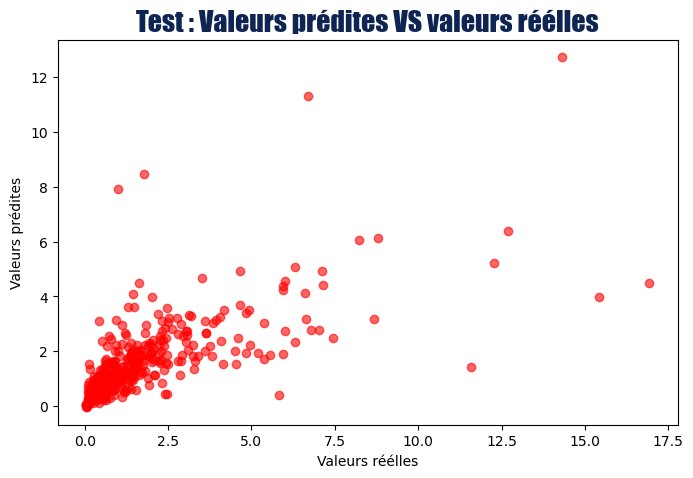

In [68]:
fig = plt.figure(figsize=(8,5))
plt.scatter(df_combined['y_test'],df_combined['y_pred_test'], color='r', alpha=.6)
plt.xlabel("Valeurs réélles")
plt.ylabel("Valeurs prédites")
plt.title("Test : Valeurs prédites VS valeurs réélles",fontsize=20, weight="bold", fontname="Impact", color="#0e2452")
plt.show()

#### 6.2.2 - Best and Worse Predictions du test

In [69]:
worst_5=df_combined.head()
worst_5[['PrimaryPropertyType', 'y_test','y_pred_test','écart_true_pred']]

PrimaryPropertyType  y_test  y_pred_test  écart_true_pred
1436               Other   16.93     4.502583        12.427417
782                Other   15.42     3.971848        11.448152
1384               Other   11.57     1.438161        10.131839
811           Laboratory   12.27     5.205319         7.064681
1203          Restaurant    1.01     7.910893         6.900893

In [70]:
best_5=df_combined.tail()
best_5[['PrimaryPropertyType', 'y_test','y_pred_test','écart_true_pred']]

PrimaryPropertyType  y_test  y_pred_test  écart_true_pred
598   Small- and Mid-Sized Office    0.29     0.292910         0.002910
757                         Other    0.36     0.357507         0.002493
462                  Large Office    0.31     0.310585         0.000585
158   Small- and Mid-Sized Office    0.36     0.360333         0.000333
1390                        Other    2.23     2.229695         0.000305

#### 6.2.3 - Analyse des erreurs du test par Primary Property type

In [71]:

nombre_individus_par_type = df_combined.groupby('PrimaryPropertyType').size()

Compar_PrimaryPropertyType = df_combined.groupby('PrimaryPropertyType')[['y_test', 'y_pred_test', 'écart_true_pred']].mean()
Compar_PrimaryPropertyType['Nombre d\'individus'] = nombre_individus_par_type
Compar_PrimaryPropertyType = Compar_PrimaryPropertyType.reset_index()
Compar_PrimaryPropertyType = Compar_PrimaryPropertyType.sort_values(by='écart_true_pred', ascending=False)

Compar_PrimaryPropertyType


PrimaryPropertyType    y_test  y_pred_test  écart_true_pred  \
10                   Restaurant  2.477500     7.695427         5.217927   
4                    Laboratory  8.935000     6.400825         2.571031   
1                      Hospital  8.210000     6.048959         2.161041   
14  Supermarket / Grocery Store  5.091333     4.091398         1.739305   
8                         Other  2.537465     1.794958         1.439260   
15                   University  1.995000     1.199739         1.358223   
2                         Hotel  2.481667     2.270310         1.046770   
7            Mixed Use Property  2.132308     1.542350         0.978413   
3                   K-12 School  1.736154     1.870594         0.635735   
11                 Retail Store  1.390312     1.096063         0.602868   
12        Self-Storage Facility  0.478333     0.841708         0.484815   
16                    Warehouse  0.771154     0.911375         0.430255   
0           Distribution Center  1.038667     0.871434         0.416504   
13  Small- and Mid-Sized Office  0.967738     0.915650         0.387733   
17             Worship Facility  1.118333     1.357804         0.340559   
9        Refrigerated Warehouse  0.830000     1.086369         0.297002   
5                  Large Office  0.823958     0.811035         0.286379   
6                Medical Office  0.944615     1.024317         0.215722   

    Nombre d'individus  
10                   4  
4                    4  
1                    1  
14                  15  
8                   71  
15                   4  
2                   18  
7                   26  
3                   13  
11                  32  
12                   6  
16                  52  
0                   15  
13                  84  
17                  24  
9                    4  
5                   48  
6                   13

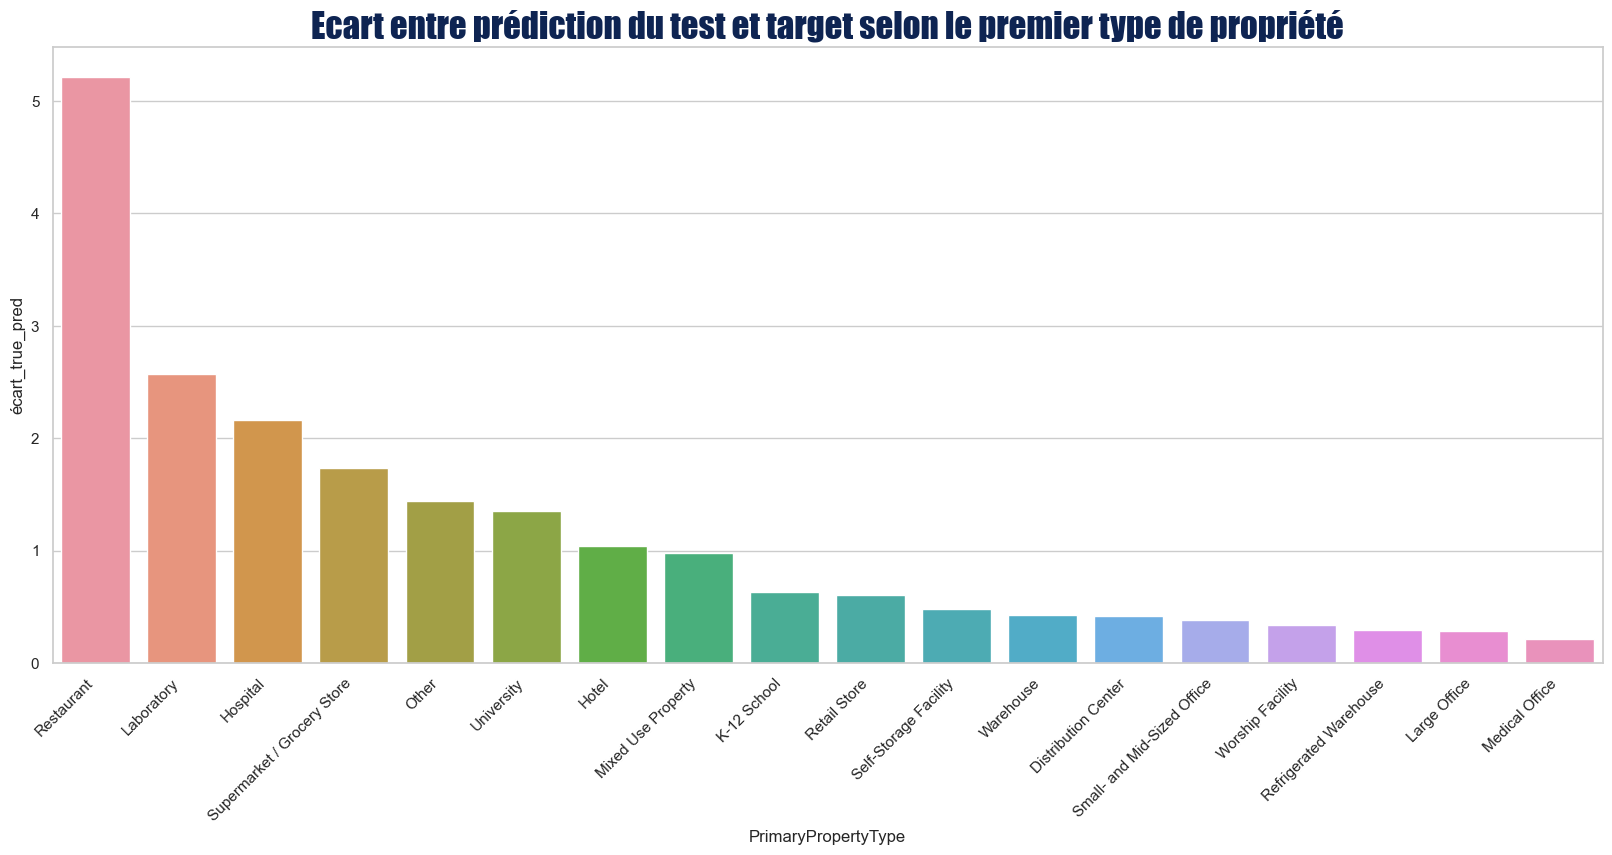

In [72]:
sns.set(style="whitegrid")
plt.figure(figsize=(20, 8))
ax = sns.barplot(x='PrimaryPropertyType', y='écart_true_pred', data=Compar_PrimaryPropertyType)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.title("Ecart entre prédiction du test et target selon le premier type de propriété", fontsize=25, weight="bold", fontname="Impact", color="#0e2452")

plt.show()



Ce sont les émissions de GAES des restaurants les + difficiles à prédire pour le Lasso

## 7 - Interprétabilité du modèle

In [73]:
best_model

Lasso(alpha=0.001)

In [74]:
best_model_explainer=shap.LinearExplainer(best_model, X_train_scaled)

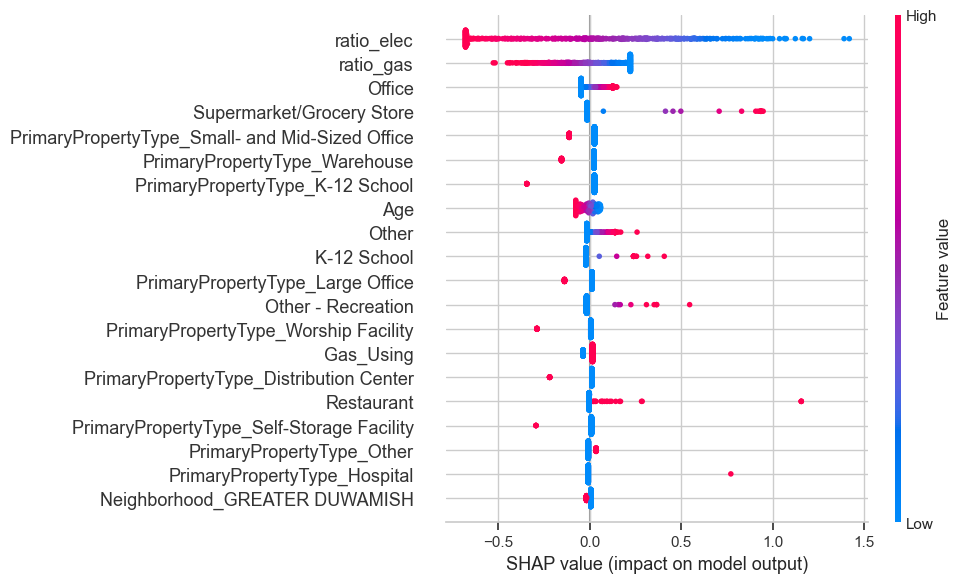

In [75]:
shap.summary_plot(best_model_explainer.shap_values(X_test_scaled),
                  features = X_test_scaled,
                  feature_names=X_test_encoded.columns,
                 plot_size=(10, 6))



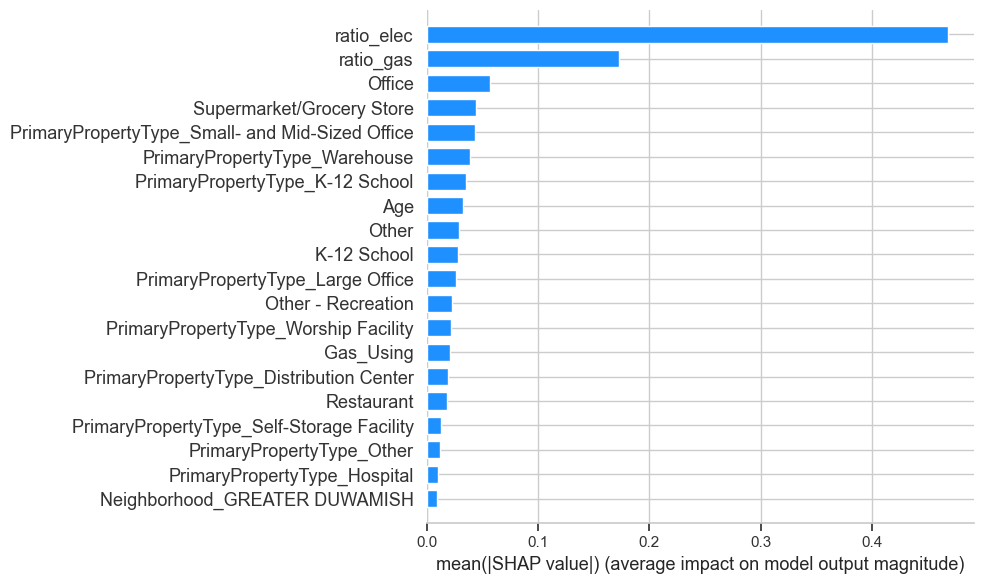

In [76]:
shap.summary_plot(best_model_explainer.shap_values(X_test_scaled),
                  feature_names=X_test_encoded.columns,
                  plot_type="bar",
                  color="dodgerblue",
                  plot_size=(10, 6))


## 8 - Avec l'EnergyStarScore

La variable "ENERGYSTARScore" comprend un grand nombre de MV. Je ne garde que les indvidus pour lesquels la variable est renseignée

In [77]:
final_df=final_df[~final_df['ENERGYSTARScore'].isna()]

In [78]:
# Nouvelle sélection de variables
X_2=final_df[[ 'ratio_elec',
             'Office',
            'PrimaryPropertyType',
            'Supermarket/Grocery Store',
            'ratio_gas',
            'Worship Facility',
            'Other',
            'Age',
            'Restaurant',
            'K-12 School',
            'Retail Store',
             'Other - Recreation',
            'Laboratory',
            'Distance_to_City_Center',
             'Neighborhood', 
            'Gas_Using',
           'ENERGYSTARScore']]
y_2=final_df["GHGEmissionsIntensity"]

In [79]:
# Nouveau split train/test
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.30, random_state=42)

In [80]:
# One Hot Encoding variables categorielles
X_train_encoded_2=pd.get_dummies(X_train_2)
X_test_encoded_2=pd.get_dummies(X_test_2)

In [81]:
# Normalisation variables numériques
scaler = RobustScaler()
X_train_scaled_2 = scaler.fit_transform(X_train_encoded_2)
X_test_scaled_2 = scaler.transform(X_test_encoded_2)

In [82]:
#Passage au log de la target
y_train_log_2 = np.log1p(y_train_2)  
y_test_log_2 = np.log1p(y_test_2)

In [83]:
# Grid Search du lasso

model_2 = Lasso()

# Paramètres à passer au Grid Search
param_grid_lasso_2 = {
    'alpha': [0.003, 0.004,0.005],
    'max_iter': [100, 500, 1000],
    'selection': ['cyclic', 'random']
}

# GridSearchCV
grid_search_lasso_2 = GridSearchCV(
    model_2,
    param_grid=param_grid_lasso_2,
    scoring={'r2': 'r2', 'adjusted_r2': adjusted_r2_scorer},
    refit='adjusted_r2', 
    cv=5,  
    verbose=1
)

In [84]:
pd.set_option('display.max_colwidth', None)
models_results_lasso_2 = evaluate_grid_search(grid_search_lasso_2, X_train_scaled_2, y_train_log_2, X_test_scaled_2, y_test_log_2, 'Lasso_avec_EnergyStarScore').reset_index(drop=True)
all_results = pd.concat([all_results.iloc[2:3, :], models_results_lasso_2], ignore_index=True)
all_results

Fitting 5 folds for each of 18 candidates, totalling 90 fits


Model_Name  Score_R2_Train  Score_R2_Test  \
0                       Lasso        0.719766       0.639536   
1  Lasso_avec_EnergyStarScore        0.825096       0.781720   

   Score_R2_Ajuste_Train  Score_R2_Ajuste_Test  Training_Time  \
0               0.706685              0.597729       0.144821   
1               0.813132              0.743361       0.454779   

                                            Best_Parameters  
0                                          {'alpha': 0.001}  
1  {'alpha': 0.003, 'max_iter': 100, 'selection': 'cyclic'}

In [85]:
best_model_2 = grid_search_lasso_2.best_estimator_

In [86]:
best_model_explainer_2=shap.LinearExplainer(best_model_2, X_train_scaled_2)

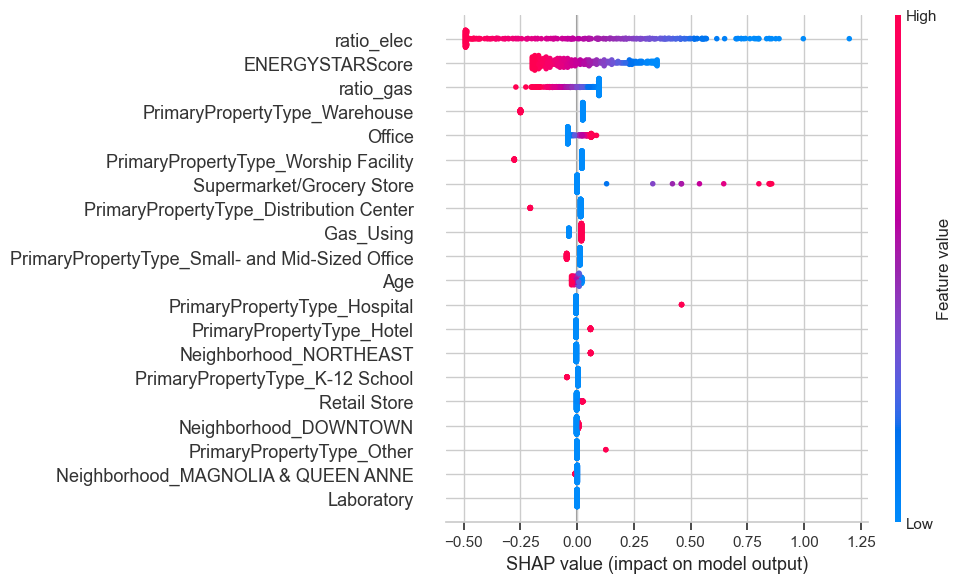

In [87]:
shap.summary_plot(best_model_explainer_2.shap_values(X_test_scaled_2),
                  features = X_test_scaled_2,
                  feature_names=X_test_encoded_2.columns,
                 plot_size=(10, 6))

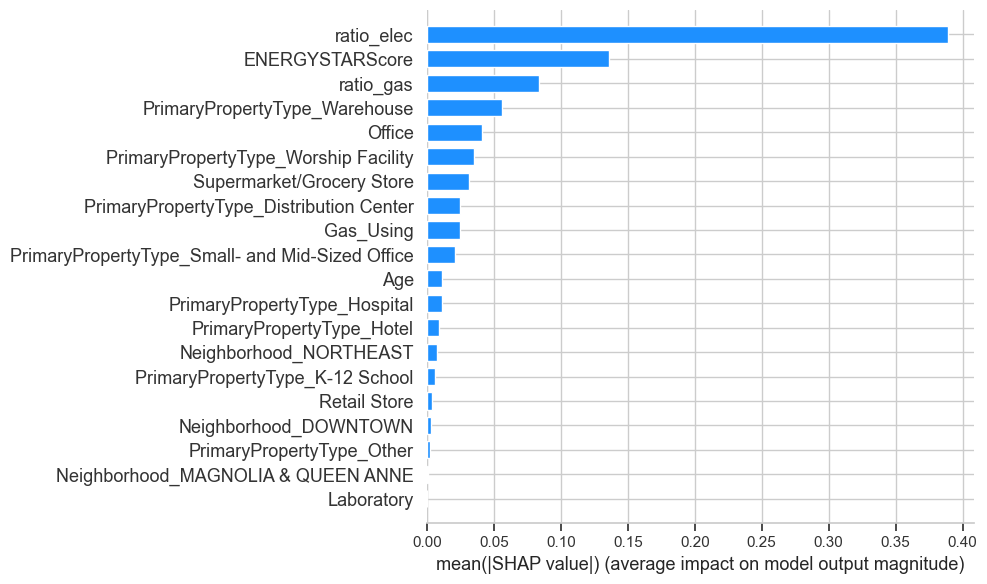

In [88]:
shap.summary_plot(best_model_explainer_2.shap_values(X_test_scaled_2),
                  feature_names=X_test_encoded_2.columns,
                  plot_type="bar",
                  color="dodgerblue",
                  plot_size=(10, 6))
